In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import time
import math 
import random
import sympy as sym
from scipy.special import binom
import openturns as ot
from scipy.stats import qmc

---

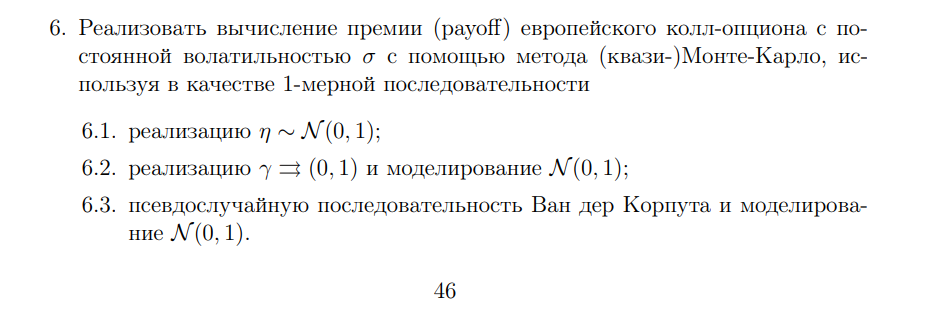

---

In [10]:
def monte_carlo_1(S0, r, sigma, K, T, N):
    Ci = np.zeros(N) 

    for i in range(N):
        Zi = np.random.normal(0,1)  
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Zi)  
        Ci[i] = np.exp(-r * T) * max(ST - K, 0)  

    return np.mean(Ci) 

In [11]:
def monte_carlo_2(S0, r, sigma, K, T, n, N):
    dt = T / n
    S = np.zeros((n + 1, N))
    S[0] = S0

    for i in range(1, n + 1):
        Z = np.random.normal(0, 1, N) 
        S[i] = S[i - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    payoff = np.maximum(S[-1] - K, 0)
    return np.mean(payoff * np.exp(-r * T))

In [19]:
def B_S( X, K, r, sigma, T):
    
    alpha_1 = (np.log(X / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    alpha_2 = (np.log(X / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return X * norm.cdf(alpha_1) - K * np.exp(-r * T) * norm.cdf(alpha_2)


Стоимость опционна колл по формуле B_S: 8.60629213587228
Стоимость опциона колл, вычисленная методом Монте-Карло 1 cпособ: 8.646277031599453
Стоимость опциона колл, вычисленная  методом Монте-Карло 2 способ: 8.611745417419298


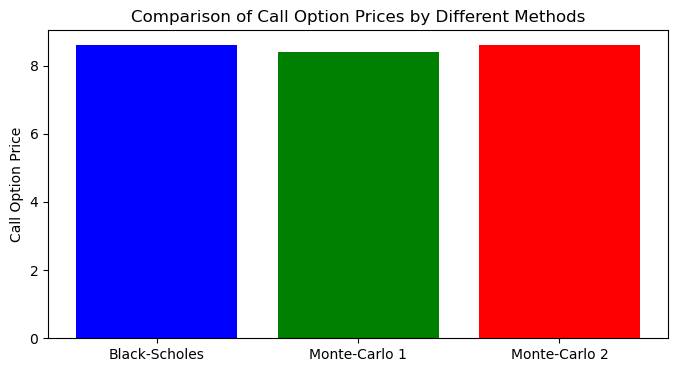

In [6]:
print(f'Стоимость опционна колл по формуле B_S: {B_S( X=100, K=120, r=0.1, sigma=0.3, T=1)}')
print(f'Стоимость опциона колл, вычисленная методом Монте-Карло 1 cпособ: {(monte_carlo_1(100, 0.1, 0.3, 120,1, 10000))}')
print(f'Стоимость опциона колл, вычисленная  методом Монте-Карло 2 способ: {monte_carlo_2(S0=100, r=0.1,sigma=0.3,K=120, T=1, n=100,N=100000)}')


B_S_value = B_S(X=100, K=120, r=0.1, sigma=0.3, T=1)  
MC1_value = monte_carlo_1(100, 0.1, 0.3, 120, 1, 10000)        
MC2_value = monte_carlo_2(S0=100, r=0.1, sigma=0.3, K=120, T=1, n=100, N=100000)  


methods = ['Black-Scholes', 'Monte-Carlo 1', 'Monte-Carlo 2']
values = [B_S_value, MC1_value, MC2_value]

plt.figure(figsize=(8, 4))
plt.bar(methods, values, color=['blue', 'green', 'red'])
plt.ylabel('Call Option Price')
plt.title('Comparison of Call Option Prices by Different Methods')
plt.show()





In [7]:
def box_muller_transform_1_1(gamma1, gamma2):
    

    s = gamma1**2 + gamma2**2
    
    if s > 1 or s == 0:
        
        gamma1 = np.random.uniform(-1, 1)
        gamma2 = np.random.uniform(-1, 1)
        
        return box_muller_transform_1_1(gamma1, gamma2)
    
    
    eta1 = gamma1 * np.sqrt(-2 * np.log(s) / s)
    eta2 = gamma2 * np.sqrt(-2 * np.log(s) / s)
    
    return eta1, eta2


def box_muller_transform_0_1(u1, u2):
    z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
    z1 = np.sqrt(-2.0 * np.log(u1)) * np.sin(2.0 * np.pi * u2)
    return z0, z1



def model_points2(num_points):
    gamma1_values = np.random.uniform(-1, 1, size=num_points)
    gamma2_values = np.random.uniform(-1, 1, size=num_points)
    eta1_values = np.zeros(num_points)
    eta2_values = np.zeros(num_points)
    for i in range(num_points):
        eta1, eta2 = box_muller_transform_1_1(gamma1_values[i], gamma2_values[i])
        eta1_values[i] = eta1
        eta2_values[i] = eta2
    return eta1_values, eta2_values

c:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


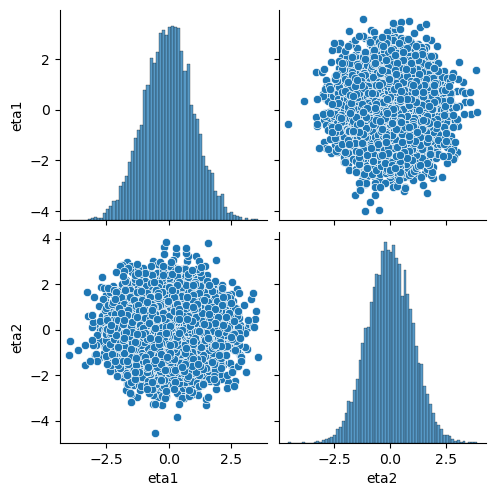

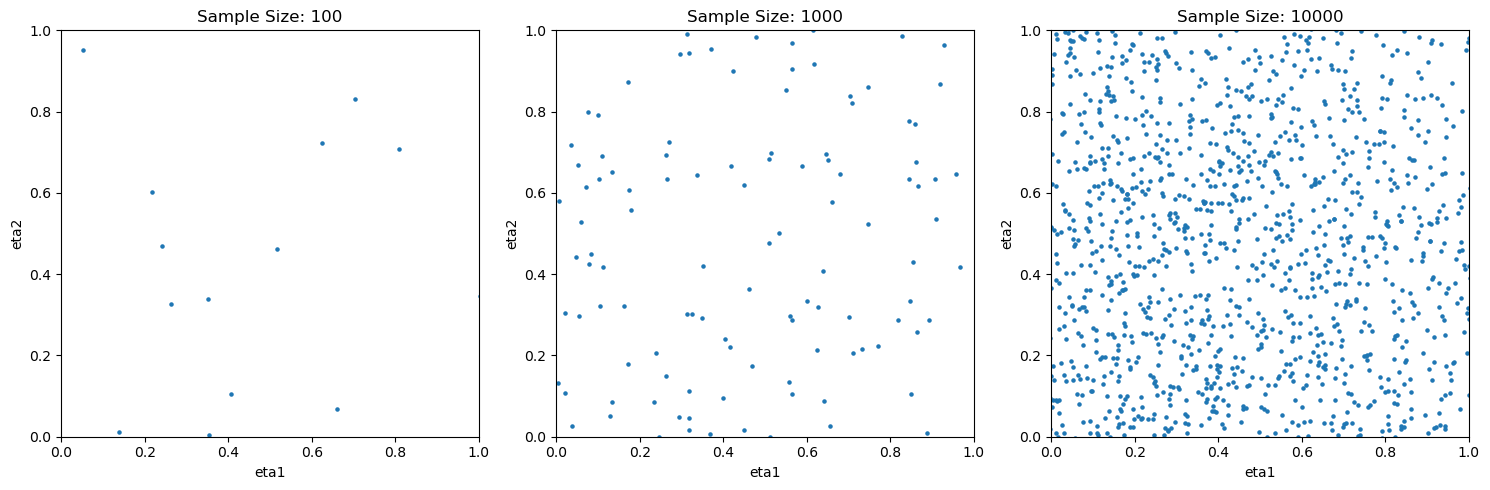

In [8]:
sample_sizes = [100, 1000, 10000]

eta1_values,eta2_values = model_points2(10000)

sns.pairplot(pd.DataFrame({'eta1': eta1_values, 'eta2': eta2_values}))
plt.show()

plt.figure(figsize=(15, 5))
for i, size in enumerate(sample_sizes):
    eta1_values, eta2_values = model_points2(size)
    plt.subplot(1, len(sample_sizes), i+1)
    plt.scatter(eta1_values, eta2_values, s=5)
    plt.title(f'Sample Size: {size}')
    plt.xlabel('eta1')
    plt.ylabel('eta2')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [9]:
def monte_carlo_3(S0, K, r, sigma, T, num_simulations):
    
    gamma1_values = np.random.uniform(-1, 1, num_simulations)
    gamma2_values = np.random.uniform(-1, 1, num_simulations)
    
    payoffs = np.zeros(num_simulations)
    
    for i in range(num_simulations):
        
        Z1, Z2 = box_muller_transform_1_1(gamma1_values[i], gamma2_values[i])
        
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z1)
        
        payoffs[i] = max(ST - K, 0)
    
    call_price = np.exp(-r * T) * np.mean(payoffs)
    
    return call_price


S0 = 100  
K = 120   
r = 0.1  
sigma = 0.3  
T = 1      
num_simulations = 100000 


call_price = monte_carlo_3(S0, K, r, sigma, T, num_simulations)
print(f"Оцененная стоимость колл-опциона: {call_price:.2f}")

Оцененная стоимость колл-опциона: 8.67


In [10]:
def van_der_corput_for_2(n, base=2):
    vdc = 0
    denom = 1
    while n:
        denom *= base
        n, remainder = divmod(n, base)
        vdc += remainder / denom
    return vdc

In [11]:
def monte_carlo_4(S0, K, r, sigma, T, num_simulations):
 
    vdc = [van_der_corput_for_2(i) for i in range(num_simulations)]
    
    payoffs = np.zeros(num_simulations)

    for i in range(num_simulations):
        
        
        Z1 = norm.ppf(vdc[i])
        
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z1)
        
        payoffs[i] = max(ST - K, 0)
    
    call_price = np.exp(-r * T) * np.mean(payoffs)
    
    return call_price


S0 = 100  
K = 120   
r = 0.2  
sigma = 0.4  
T = 1      
num_simulations = 10000


call_price = monte_carlo_4(S0, K, r, sigma, T, num_simulations)
print(f"Стоимость колл-опциона Монте карло_4: {call_price}")
print(f'Стоимость кодд-опциона по формуле:  {B_S( X=100, K=120, r=0.2, sigma=0.4, T=1)}')

Стоимость колл-опциона Монте карло_4: 16.55506348006161
Стоимость кодд-опциона по формуле:  16.604348790789622


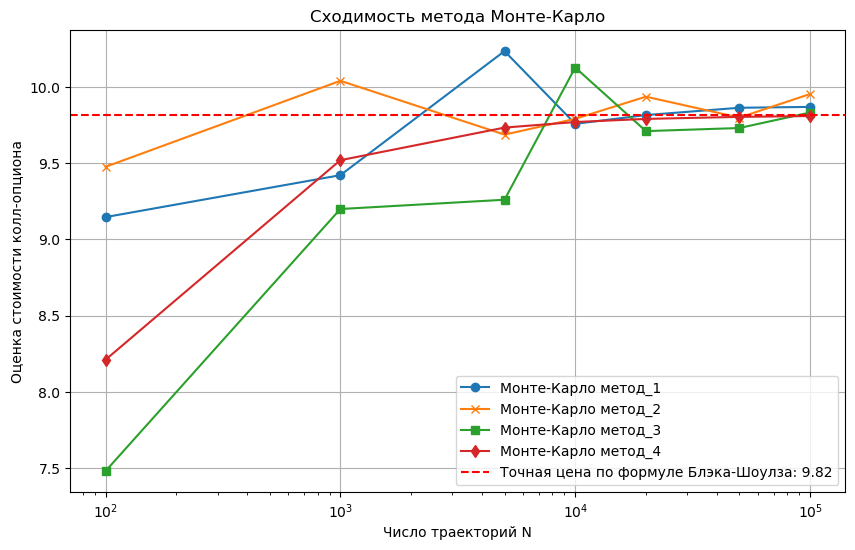

Стоимость опциона колл по формуле B_H: 5.653916736309725
Стоимость опциона колл, вычисленная методом Монте-Карло_1 способ: 5.77700140218006
Стоимость опциона колл, вычисленная  методом Монте-Карло_2 способ: 5.610902676063368
Стоимость опциона колл, вычисленная  методом Монте-Карло_3 способ: 5.666530658308995
Стоимость опциона колл, вычисленная  методом Монте-Карло_4 способ: 5.647652085069399


In [12]:
N_values = [100, 1000, 5000, 10000, 20000, 50000, 100000]
estimates_2 = [monte_carlo_2(S0=100, r=0.02, sigma=0.4, K=120, T=1, n=100, N=N) for N in N_values]
estimates_1 = [monte_carlo_1(S0=100, r=0.02, sigma=0.4, K=120, T=1, N=N) for N in N_values]
estimates_3 = [monte_carlo_3(S0=100, K=120, r=0.02, sigma=0.4, T=1, num_simulations=N )for N in N_values]
estimates_4 = [monte_carlo_4(S0=100, K=120, r=0.02, sigma=0.4, T=1,num_simulations=N) for N in N_values]

S0 = 100
exact_price = B_S(X=100, K=120, r=0.02, sigma=0.4, T=1)

plt.figure(figsize=(10, 6))
plt.plot(N_values, estimates_1, marker='o', label='Монте-Карло метод_1')
plt.plot(N_values, estimates_2, marker='x', label='Монте-Карло метод_2')
plt.plot(N_values, estimates_3, marker='s', label='Монте-Карло метод_3')
plt.plot(N_values, estimates_4, marker='d', label='Монте-Карло метод_4')
plt.axhline(y=exact_price, color='r', linestyle='--', label=f'Точная цена по формуле Блэка-Шоулза: {round(exact_price, 2)}')
plt.xscale('log')
plt.title('Сходимость метода Монте-Карло')
plt.xlabel('Число траекторий N')
plt.ylabel('Оценка стоимости колл-опциона')
plt.legend()
plt.grid(True)
plt.show()

print(f'Стоимость опциона колл по формуле B_H: {B_S(X=100, K=140, r=0.02, sigma=0.4, T=1)}')
print(f'Стоимость опциона колл, вычисленная методом Монте-Карло_1 способ: {(monte_carlo_1(100, 0.02, 0.4, 140,1, 10000))}')
print(f'Стоимость опциона колл, вычисленная  методом Монте-Карло_2 способ: {monte_carlo_2(S0=100, r=0.02,sigma=0.4,K=140, T=1, n=100,N=100000)}')
print(f"Стоимость опциона колл, вычисленная  методом Монте-Карло_3 способ: {monte_carlo_3(S0=100, K=140, r=0.02, sigma=0.4, T=1, num_simulations=100000)}")
print(f"Стоимость опциона колл, вычисленная  методом Монте-Карло_4 способ: {monte_carlo_4(S0=100, K=140, r=0.02, sigma=0.4, T=1, num_simulations=100000 )}")

In [16]:
def is_pr(num):
    return num > 1 and all(num % i for i in range(2, num))

def get_pr_arr(n):
    primes, num = [], 2
    while len(primes) < n: primes.append(num) if is_pr(num) else None; num += 1
    return primes


print(is_pr(11))             
print(get_pr_arr(5))   


True
[2, 3, 5, 7, 11]


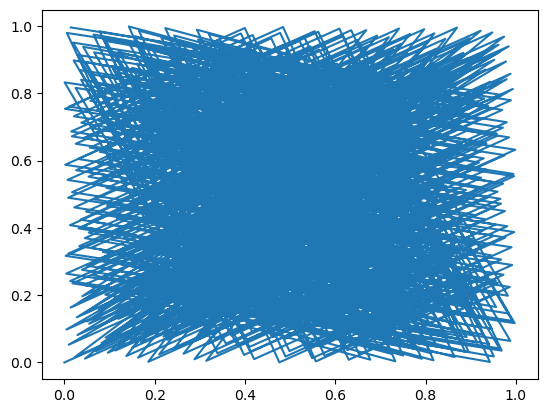

In [17]:
def base_fraction(base, number):
    result = 0.0
    factor = 1.0
    while number > 0:
        factor /= base
        result += (number % base) * factor
        number //= base
    return result


def vdc_any(base, n0, n):
    return np.array([base_fraction(base, i) for i in range(n0, n)])


d0 = vdc_any(3,0,1000)
d1 = vdc_any(5,0,1000)

d0_ = pd.DataFrame(d0, columns=['1'])
d1_ = pd.DataFrame(d1, columns=['0'])
plt.plot(d0,d1)
plt.show()

c:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


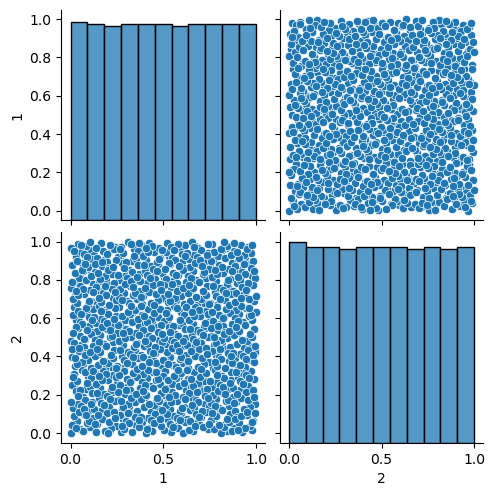

In [18]:
def get_pr(start_num, count):
    primes, num = [], start_num
    while len(primes) < count: primes.append(num) if is_pr(num) else None; num += 1
    return primes

def halton(dim, n0, n):
    bases = get_pr_arr(dim)
    return np.array([vdc_any(base, n0, n) for base in bases]).T

check = halton(2, 0, 1000)
check_df = pd.DataFrame(check, columns=['1', '2'])
sns.pairplot(check_df)
plt.show()

c:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


[]

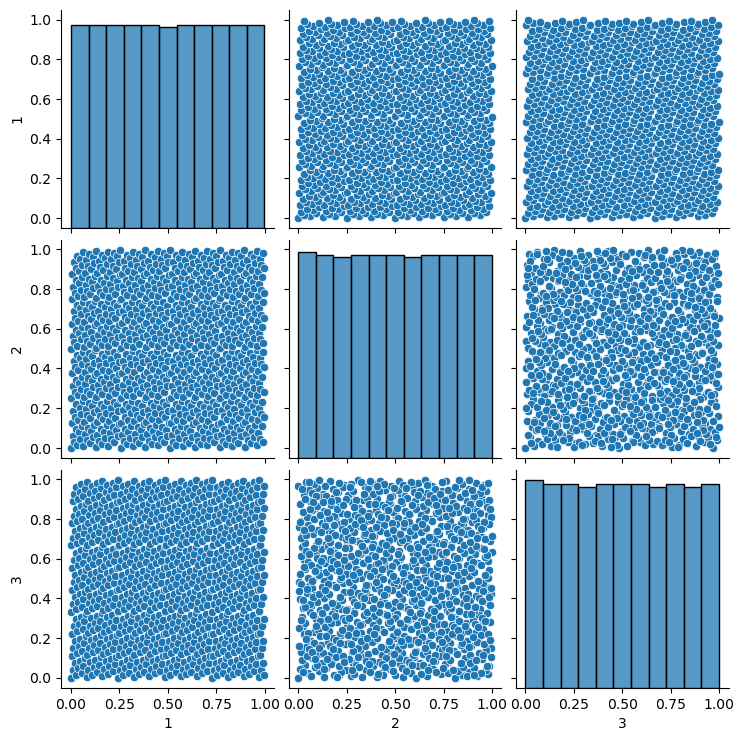

In [19]:
def hammersley(dim, n0, n):
    W = np.zeros((n - n0, 1))
    for i in range(n0, n):
        W[i - n0] = i / (n - n0)
    W2 = halton(dim - 1, n0, n)
    return np.concatenate((W, W2), axis=1)

check_hamm = hammersley(3,0,1000)
check_hamm_df = pd.DataFrame(check_hamm, columns=['1','2','3'])
sns.pairplot(check_hamm_df)
plt.plot()

c:\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


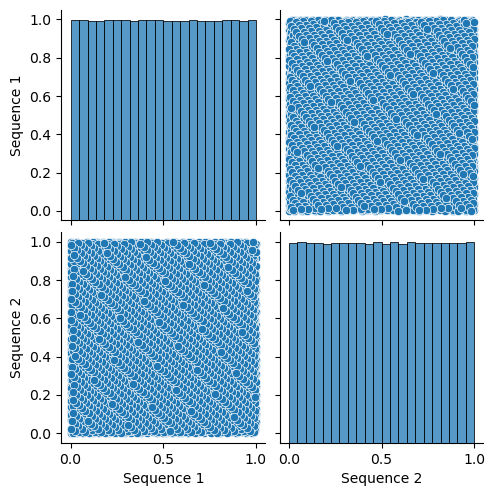

In [48]:
def kroncker(dim, n0, n):
    sqrt_primes = [np.sqrt(p) for p in get_pr(n0, dim)]
    arr = np.arange(n0, n)
    W = np.array([[round((num * sqrt) % 1, 10) for num in arr] for sqrt in sqrt_primes])
    if not all(len(row) == len(W[0]) for row in W):
        print("Ошибка: не все списки имеют одинаковую длину")
    return W.T



data = kroncker(2, 0, 10000)


df = pd.DataFrame(data, columns=['Sequence 1', 'Sequence 2'])
sns.pairplot(df)
plt.show()


In [41]:
def asian_option_price_mc(S0, K, T, r, sigma, n, m):
    dt = T / m
    discount_factor = np.exp(-r * T)
    
    payoffs = np.zeros(n)
    
    for i in range(n):
        S = np.zeros(m + 1)
        S[0] = S0
        
        for j in range(1, m + 1):
            Z = np.random.standard_normal()
            S[j] = S[j-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        
        S_mean = np.mean(S[1:])
        payoff = max(S_mean - K, 0)
        payoffs[i] = discount_factor * payoff
    
    C_star = np.mean(payoffs)
    return C_star

In [42]:
def faure_sequence(n,dim):
    seq = ot.FaureSequence(dim + 1)
    return np.array(seq.generate(n))


def sobol(n,d):
    sampler = qmc.Sobol(d)
    points = sampler.random(n)
    return points

In [43]:
def sigma_func(S):
    return 0.1

---

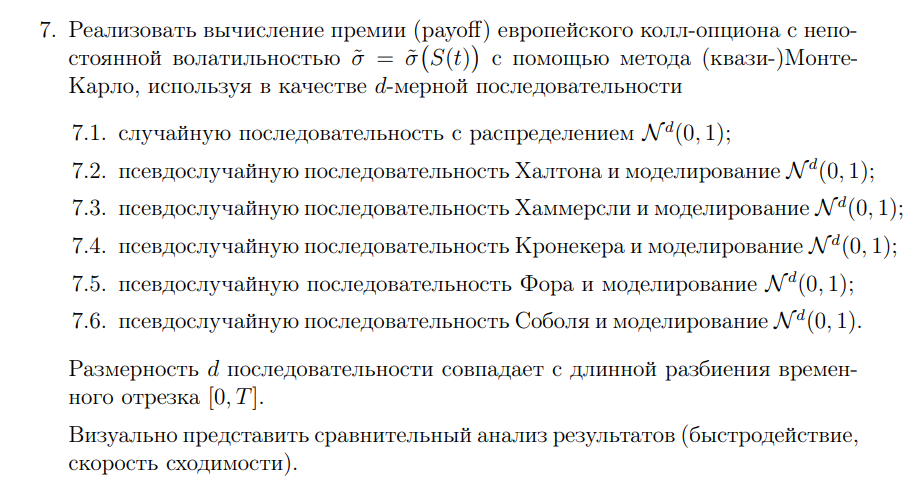

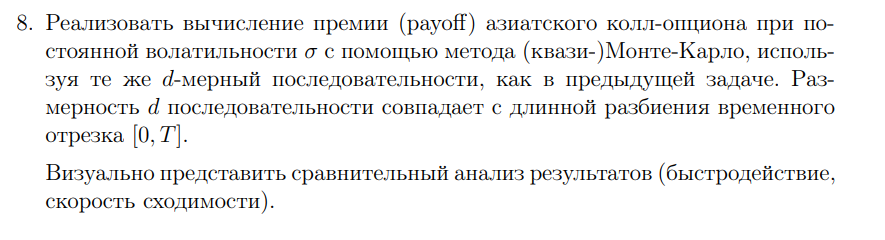

---

In [7]:
sigma = 0.1
r = 0.12
S0 = 100
K = 100
dim = 30
n = 10**4
n0 = 0
T = 1



In [13]:
halton_seq = norm.ppf(halton(dim, n0, n))
hammersley_seq = norm.ppf(hammersley(dim, n0, n))
kroncker_seq = norm.ppf(kroncker(dim, n0, n))
faura_seq = norm.ppf(faure_sequence(n, dim))
sobol_seq = norm.ppf(sobol(n, dim))


c:\anaconda3\Lib\site-packages\scipy\stats\_qmc.py:804: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


In [22]:
def monte_carlo_(S0, K, T, r, sigma, n, sequence):
    dt = T / sequence.shape[1]
    payoff_sum = 0
    discount_factor = np.exp(-r * T)
    
    for i in range(n):
        
        ST = S0
        seq = sequence[i]
        
        for j in range(seq.shape[0]):
            
            ST *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * seq[j])
        
        payoff_sum += max(ST - K, 0)
        
    return discount_factor * payoff_sum / n



In [15]:
def monte_carlo_for_asian(S0, K, T, r, sigma, n, sequence):

    dt = T / sequence.shape[1]
    discount_factor = np.exp(-r * T)
    payoffs = np.zeros(n)
    
    for i in range(n):
        ST = S0
        ST_all = np.zeros(sequence.shape[1])
        
        for t in range(sequence.shape[1]):
            ST *= np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * sequence[i, t])
            ST_all[t] = ST
        
        S_mean = np.mean(ST_all)
        payoffs[i] = max(S_mean - K, 0)
    
    return discount_factor * np.mean(payoffs)

---

## Results 

In [16]:
kroncker_price = monte_carlo_for_asian(S0, K, T, r, sigma, n, kroncker_seq)

halton_price = monte_carlo_for_asian(S0, K, T, r, sigma, n, halton_seq)

hammersley_price = monte_carlo_for_asian(S0, K, T, r, sigma, n, hammersley_seq)

faura_price = monte_carlo_for_asian(S0, K, T, r, sigma, n, faura_seq)

sobol_price = monte_carlo_for_asian(S0, K, T, r, sigma, n, sobol_seq)


In [17]:
list_pr_as = [kroncker_price, halton_price, hammersley_price, faura_price, sobol_price]

for i in list_pr_as:
    print(i)

6.1535865759275925
6.048301457342889
6.062316310655676
6.078542893739564
6.145251619021761


In [18]:
kr_eur = monte_carlo_(S0, K, T, r, sigma, n, kroncker_seq)
halt_eur = monte_carlo_(S0, K, T, r, sigma, n, halton_seq)
hamm_eur = monte_carlo_(S0, K, T, r, sigma, n, hammersley_seq)
faura_eur = monte_carlo_(S0, K, T, r, sigma, n, faura_seq)
sobol_eur = monte_carlo_(S0, K, T, r, sigma, n, sobol_seq)


In [19]:
list_eur = [kr_eur, halt_eur, hamm_eur, faura_eur, sobol_eur]
for j in list_eur:
    print(j)

11.859978545621956
11.577565802736048
11.614073544210937
11.700085768335667
11.834892894865662


## Скорость сходимости 

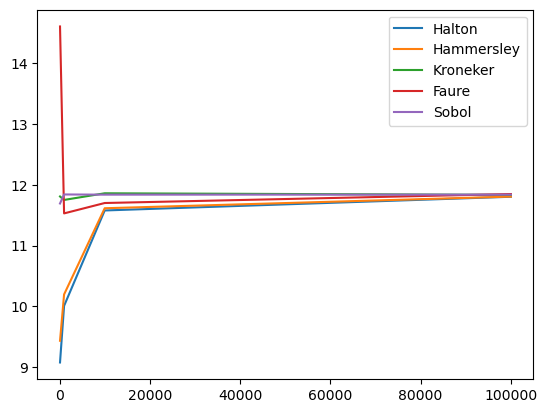

In [84]:
n_list = [10**2, 10**3, 10**4, 10**5]

price_halton = []
price_hammersli = []
price_kroncker = []
price_faura = []
price_sobol = []



for n in n_list:
    
    
    halton_seq = norm.ppf(halton(dim, n0, n))
    hammersley_seq = norm.ppf(hammersley(dim, n0, n))
    kroncker_seq = norm.ppf(kroncker(dim, n0, n))
    faura_seq = norm.ppf(faure_sequence(n, dim))
    sobol_seq = norm.ppf(sobol(n, dim))

    
    price_kroncker.append(monte_carlo_(S0, K, T, r, sigma, n, kroncker_seq))
    price_halton.append(monte_carlo_(S0, K, T, r, sigma, n, halton_seq))
    price_hammersli.append(monte_carlo_(S0, K, T, r, sigma, n, hammersley_seq))
    price_faura.append(monte_carlo_(S0, K, T, r, sigma, n, faura_seq))
    price_sobol.append(monte_carlo_(S0, K, T, r, sigma, n, sobol_seq))
    

plt.plot(n_list, price_halton, label='Halton')
plt.plot(n_list, price_hammersli, label='Hammersley')
plt.plot(n_list, price_kroncker, label='Kroneker')
plt.plot(n_list, price_faura, label='Faure')
plt.plot(n_list, price_sobol, label='Sobol')

plt.legend()
plt.show()


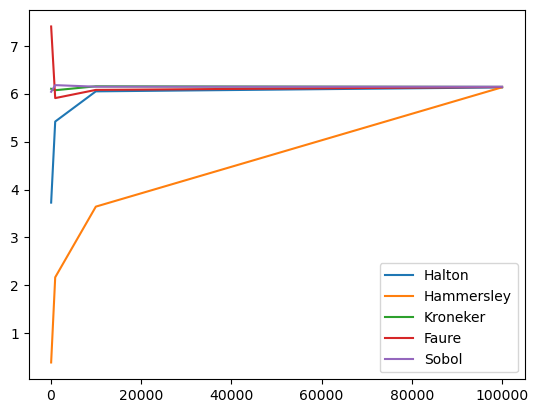

In [85]:
price_halton1 = []
price_hammersli1 = []
price_kroncker1 = []
price_faura1 = []
price_sobol1 = []



for n in n_list:
    
    price_kroncker1.append(monte_carlo_for_asian(S0, K, T, r, sigma, n, kroncker_seq))
    price_halton1.append(monte_carlo_for_asian(S0, K, T, r, sigma, n, halton_seq))
    price_hammersli1.append(monte_carlo_for_asian(S0, K, T, r, sigma, n, hammersley_seq))
    price_faura1.append(monte_carlo_for_asian(S0, K, T, r, sigma, n, faura_seq))
    price_sobol1.append(monte_carlo_for_asian(S0, K, T, r, sigma, n, sobol_seq))
    

plt.plot(n_list, price_halton1, label='Halton')
plt.plot(n_list, price_hammersli1, label='Hammersley')
plt.plot(n_list, price_kroncker1, label='Kroneker')
plt.plot(n_list, price_faura1, label='Faure')
plt.plot(n_list, price_sobol1, label='Sobol')

plt.legend()
plt.show()


In [12]:
def diff_european_explicit(S, K, r, sigma, T,  N_x, N_t):

    x_grid = np.linspace(0, S, N_x+1)
    t_grid = np.linspace(0, T, N_t+1)
    
    G = np.zeros((N_x+1, N_t+1))
    delta_x = S / N_x  # h
    delta_t = T / N_t  # τ
    
    G[:, -1] = np.maximum(x_grid - K, 0)                    
    G[0, :] = 0                                       
    G[-1, :] = S - K * np.exp(-r * (T - t_grid))        
    
    alpha = 0.5 * delta_t * sigma**2 * (x_grid / delta_x)**2
    beta = 0.5 * delta_t * r * x_grid / delta_x
    gamma = -delta_t * r
    
    for n in range(N_t-1, -1, -1):  
        for i in range(1, N_x):  
            G[i, n] = G[i, n+1] + alpha[i] * (G[i+1, n+1] - 2 * G[i, n+1] + G[i-1, n+1]) + beta[i] * (G[i+1, n+1] - G[i-1, n+1]) + gamma * G[i, n+1]
    
    
    df = pd.DataFrame(np.array(G).T)
    
    return delta_t, delta_x, x_grid, G, df


412.65942675236795 : Цена по явной схеме
418.0533221988707 : Цена по формуле B_S
При:  τ < h^2/2


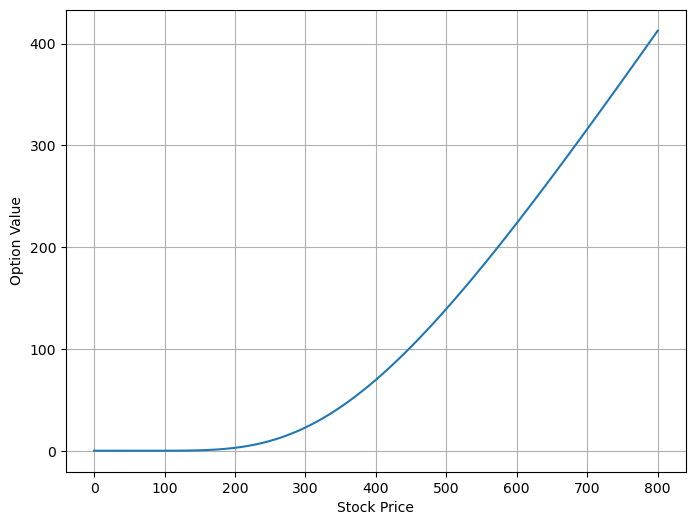

tau: 0.0025 h^2/2: 32.0


In [15]:
S = 800 
K = 820 
r = 0.15  
sigma = 0.2
T = 5  
N_x = 100
N_t = 2000
t = 0

d_1, d_2, Xs_grid, Q, df_1 = diff_european_explicit(S, K, r, sigma, T, N_x, N_t)

tau = int((N_t/T)*t)


price = df_1[N_x][tau]

pricr_BS = B_S(S, K, r, sigma, T)

print(price,': Цена по явной схеме')
print( pricr_BS, ': Цена по формуле B_S')

if N_t < N_x:
    print('При: τ > h^2/2')
    plt.figure(figsize=(8, 6))
    plt.plot(Xs_grid, Q[:,0])
    plt.xlabel('Stock Price')
    plt.ylabel('Option Value')
    plt.grid(True)
    plt.show()
else:
    print('При:  τ < h^2/2')
    plt.figure(figsize=(8, 6))
    plt.plot(Xs_grid, Q[:,0])
    plt.xlabel('Stock Price')
    plt.ylabel('Option Value')
    plt.grid(True)
    plt.show()

h_2 = d_2**2/2


print('tau:', d_1, 'h^2/2:',h_2)

In [19]:
from sympy import symbols, Matrix

def finite_difference_coefficients(points, derivative_order):
    n = len(points)
    A = np.zeros((n, n))
    b = np.zeros(n)
    
    
    x, h = symbols('x h')
    for i in range(n):
        point = points[i]
        for j in range(n):
            A[i, j] = point**j / np.math.factorial(j)
        if i == derivative_order:
            b[i] = 1
    
    
    coefficients = np.linalg.solve(A, b)
    
    return coefficients


points_2 = [1, 2]  
points_3 = [1, 2, 3]  
points_4 = [1, 2, 3, 4]  
points_5 = [1, 2, 3, 4, 5]  


coeff_2_first_derivative = finite_difference_coefficients(points_2, 1)
coeff_3_first_derivative = finite_difference_coefficients(points_3, 1)
coeff_4_first_derivative = finite_difference_coefficients(points_4, 1)
coeff_5_first_derivative = finite_difference_coefficients(points_5, 1)


coeff_2_second_derivative = finite_difference_coefficients(points_2, 2)
coeff_3_second_derivative = finite_difference_coefficients(points_3, 2)
coeff_4_second_derivative = finite_difference_coefficients(points_4, 2)
coeff_5_second_derivative = finite_difference_coefficients(points_5, 2)

print("Коэффициенты для первой производной:")
print("2 points:", coeff_2_first_derivative)
print("3 points:", coeff_3_first_derivative)
print("4 points:", coeff_4_first_derivative)
print("5 points:", coeff_5_first_derivative)

print("\nДля второй производной:")
print("2 points:", coeff_2_second_derivative)
print("3 points:", coeff_3_second_derivative)
print("4 points:", coeff_4_second_derivative)
print("5 points:", coeff_5_second_derivative)


Коэффициенты для первой производной:
2 points: [-1.  1.]
3 points: [-3.  4. -2.]
4 points: [-6.   9.5 -8.   3. ]
5 points: [-10.          17.83333333 -19.66666667  13.          -4.        ]

Для второй производной:
2 points: [0. 0.]
3 points: [ 1.  -1.5  1. ]
4 points: [ 4. -7.  7. -3.]
5 points: [ 10.  -19.5  24.5 -18.    6. ]


In [5]:
def black_scholes_call(S, K, r, sigma, T, t,):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    d2 = d1 - sigma * np.sqrt(T - t)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * (T - t)) * norm.cdf(d2)
    return call_price

In [10]:
def SLE_algorithm(a, b, c, d):
    n = len(d)
   
    c_prime = np.zeros(n-1)
    d_prime = np.zeros(n)
    
    c_prime[0] = c[0] / b[0]
    d_prime[0] = d[0] / b[0]
    
    for i in range(1, n-1):
        denominator = b[i] - a[i-1] * c_prime[i-1]
        c_prime[i] = c[i] / denominator
        d_prime[i] = (d[i] - a[i-1] * d_prime[i-1]) / denominator
    
    d_prime[-1] = (d[-1] - a[-2] * d_prime[-2]) / (b[-1] - a[-2] * c_prime[-2])
    
    
    x = np.zeros(n)
    x[-1] = d_prime[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]
    
    return x



def BSM_implicit(S_max,S0, K, r, sigma, M, N, T, t0=0):

    S_grid = np.linspace(S0, S_max, M + 1)
    t_grid = np.linspace(t0, T, N + 1)
    
    V = np.zeros((M + 1, N + 1))
    delta_S = S_grid[1] - S_grid[0]# h
    delta_t = t_grid[1] - t_grid[0] # t

    V[:, -1] = np.maximum(S_grid - K, 0)
    V[0, :] = 0
    V[-1, :] = S_max - K * np.exp(-r * (T - t_grid))
    
    alpha = 0.5 * delta_t * sigma**2 * (S_grid / delta_S)**2
    beta = 0.5 * delta_t * r * S_grid / delta_S
    gamma = -delta_t * r

    lower_diag = -alpha[2:M] + beta[2:M]
    main_diag = 1 + 2 * alpha[1:M] - gamma
    upper_diag = -alpha[1:M-1] - beta[1:M-1]

    for n in range(N-1, -1, -1):
        b = V[1:M, n+1].copy()
        b[0] += (alpha[1] - beta[1]) * V[0, n]
        b[-1] += (alpha[-2] + beta[-2]) * V[-1, n]

        V[1:M, n] = SLE_algorithm(lower_diag, main_diag, upper_diag, b)

    return V.T, delta_S, delta_t



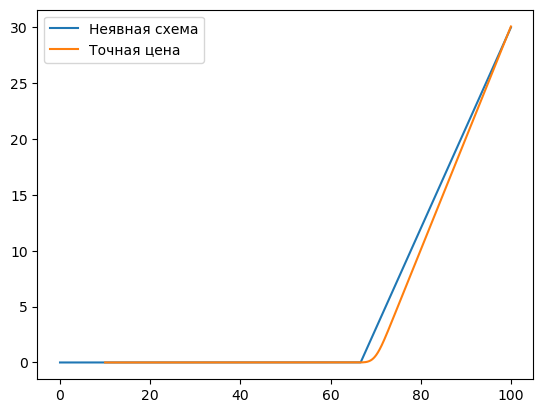

In [13]:
S0 = 10
K = 70
S_max = 100
r = 0.12
sigma = 0.2
T = 1
t0 = 0.99
M = 10**5
N = 10**1
dim = 20
n = 1000
n0 = 0


V_implicit, _, _ = BSM_implicit(S_max, S0, K, r, sigma, M, N, T, t0)
V_implicit_last = V_implicit[-1]



S_grid = np.linspace(0, S_max, M + 1)
plt.plot(S_grid[int(S_max / (M + 1) * S0):], V_implicit_last[int(S_max / (M + 1) * S0):], label='Неявная схема')

S_grid_bs = np.linspace(S0, S_max, M + 1)  
plt.plot(S_grid_bs, black_scholes_call(S_grid_bs, K, r, sigma, T=1, t=0.99), label='Точная цена')

plt.legend()
plt.show()





In [14]:
def compute_volatility(S, V_SS, sigma, C, M):
    return sigma**2 * (1 + 3 * ((C**2 * M / (2 * np.pi)) * S * V_SS)**(1/3))


In [15]:

def BSM_diff_european_option_implicit_variable_volatility(S_max, K, r, sigma, T, t, N_S, N_t, S, C, M):
    S_grid = np.linspace(0, S_max, N_S + 1)
    t_grid = np.linspace(0, T, N_t + 1)
    
    V = np.zeros((N_S + 1, N_t + 1))
    delta_S = S_max / N_S
    delta_t = T / N_t

    V[:, -1] = np.maximum(S_grid - K, 0)  
    V[0, :] = 0  
    V[-1, :] = S_max - K * np.exp(-r * (T - t_grid))  
    
    for n in range(N_t-1, -1, -1):
        alpha = 0.5 * delta_t * sigma**2 * (S_grid / delta_S)**2
        beta = 0.5 * delta_t * r * S_grid / delta_S
        gamma = -delta_t * r
        
        lower_diag = -alpha[2:N_S] + beta[2:N_S]
        main_diag = 1 + 2 * alpha[1:N_S] - gamma
        upper_diag = -alpha[1:N_S-1] - beta[1:N_S-1]

        b = V[1:N_S, n+1].copy()
        b[0] += (alpha[1] - beta[1]) * V[0, n]
        b[-1] += (alpha[-2] + beta[-2]) * V[-1, n]
        
        V[1:N_S, n] = SLE_algorithm(lower_diag, main_diag, upper_diag, b)

        for i in range(1, N_S):
            V_SS = (V[i+1, n] - 2 * V[i, n] + V[i-1, n]) / delta_S**2
            sigma_tilde_sq = compute_volatility(S_grid[i], V_SS, sigma, C, M)
            alpha[i] = 0.5 * delta_t * sigma_tilde_sq * (S_grid[i] / delta_S)**2

    df = pd.DataFrame(np.array(V).T)

    S_idx = int((N_S / S_max) * S)
    tau = int((N_t / T) * t)

    price_option = df[S_idx][tau]

    return price_option, S_grid, V, df

C:\Users\Астемир\AppData\Local\Temp\ipykernel_4016\1840939978.py:2: RuntimeWarning: invalid value encountered in scalar power
  return sigma**2 * (1 + 3 * ((C**2 * M / (2 * np.pi)) * S * V_SS)**(1/3))


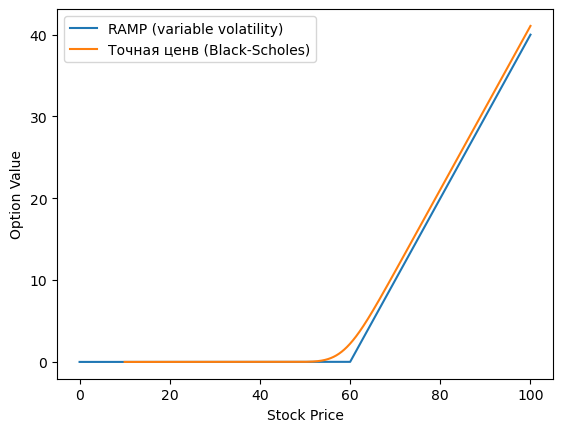

The option price at S = 10 and t = 0.88 is: 3.9196808105226784e-41


In [16]:
S0 = 10
K = 60
S_max = 100
r = 0.15
sigma = 0.2
T = 1
t0 = 0.88
N_S = 10**4
N_t = 10**2
C = 0.1
M = 0.01


price_option, S_grid, V, df = BSM_diff_european_option_implicit_variable_volatility(S_max, K, r, sigma, T, t0, N_S, N_t, S0, C, M)
V_implicit_last = V[:, -1]


plt.plot(S_grid[int(S_max / (N_S + 1) * S0):], V_implicit_last[int(S_max / (N_S + 1) * S0):], label='RAMP (variable volatility)')


S_grid_bs = np.linspace(S0, S_max, N_S + 1)  
plt.plot(S_grid_bs, black_scholes_call(S_grid_bs, K, r, sigma, T=1, t=t0), label='Точная ценв (Black-Scholes)')

plt.xlabel('Stock Price')
plt.ylabel('Option Value')
plt.legend()
plt.show()

print(f"The option price at S = {S0} and t = {t0} is: {price_option}")